# 1) Import Libraries
---

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [3]:
df = pd.read_csv("/content/spam.csv", encoding = 'ISO-8859-1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# delete unnecessary columns 
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

In [6]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# rename columns 
df.columns = ['labels', 'data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# Create Binary labels
df['b_labels']  =df['labels'].map({'ham': 0, 'spam':1})
y = df['b_labels'].values

In [9]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(df['data'], y, test_size = .33, random_state = 123)

In [10]:
# convert sentences to sequences
max_vocab_size = 20000
tokenizer = Tokenizer(num_words= max_vocab_size)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test  = tokenizer.texts_to_sequences(X_test)

In [11]:
# Check word index mapping (to check the number of words in vocab)
word2idx = tokenizer.word_index
V = len(word2idx)
print('Total number of unique tokens are: %s' %V)

Total number of unique tokens are: 7225


In [12]:
# pad sequences to get N * T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

Shape of data train tensor: (3733, 162)


In [13]:
# set the value of T to get sequence length
T = data_train.shape[1]
print(T)

162


In [14]:
# pad the test set
data_test = pad_sequences(sequences_test, maxlen = T)
# maxlen = T, to truncate longer sentences in test set
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 162)


# 2) Building The Model
---

In [16]:
# Choose embedding dimensionality
D = 20 # this is a hyper parameter, we can choose any word vector size that we want

# Hidden state vectorsize ( dimensionality)
M = 15

# Input layer
i = Input(shape = (T,)) # Input layer takes in sequences of integers, so shape is T

# Embedding layer
x = Embedding(V+1, D)(i) # This takes in sequencces of integers and returns sequences of word vectors
# This will be an N * T * D array
# we want size of embedding to (V+1) x D, because first word index starts from 1 and not 0

# LSTM layer
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)

# Dense layer
x = Dense(1, activation= 'sigmoid')(x)
# it is an binary classification problem, so we are using activation function = 'sigmoid'

model = Model(i, x)

In [17]:
# compile the model
model.compile(optimizer= 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [18]:
# Train the model
r = model.fit(x = data_train, y = y_train, epochs = 10, validation_data = (data_test, y_test))

Epoch 1/10
117/117 [==============================] - 9s 75ms/step - loss: 0.4712 - accuracy: 0.8604 - val_loss: 0.3819 - val_accuracy: 0.8711
Epoch 2/10
117/117 [==============================] - 9s 75ms/step - loss: 0.3892 - accuracy: 0.8634 - val_loss: 0.3555 - val_accuracy: 0.8711
Epoch 3/10
117/117 [==============================] - 9s 75ms/step - loss: 0.3256 - accuracy: 0.8634 - val_loss: 0.2771 - val_accuracy: 0.8711
Epoch 4/10
117/117 [==============================] - 9s 78ms/step - loss: 0.2354 - accuracy: 0.8650 - val_loss: 0.2068 - val_accuracy: 0.8940
Epoch 5/10
117/117 [==============================] - 9s 80ms/step - loss: 0.1532 - accuracy: 0.9614 - val_loss: 0.1510 - val_accuracy: 0.9734
Epoch 6/10
117/117 [==============================] - 9s 78ms/step - loss: 0.1070 - accuracy: 0.9882 - val_loss: 0.1354 - val_accuracy: 0.9685
Epoch 7/10
117/117 [==============================] - 10s 86ms/step - loss: 0.0788 - accuracy: 0.9893 - val_loss: 0.1170 - val_accuracy: 0.966

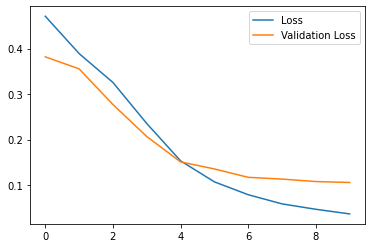

In [19]:
# Loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label = 'Loss')
plt.plot(r.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

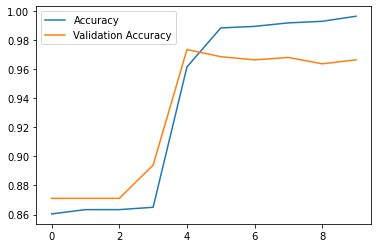

In [20]:
# Accuracy per iteration
plt.plot(r.history['accuracy'], label = 'Accuracy')
plt.plot(r.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.show()